# Installation 

* git clone https://github.com/hemantaph/gwsnr.git
* cd gwsnr .
* python setup.py install.

# modified Findchirp method, or Half Scaling method. 

* SNR : $$ \rho= \left( \frac{1 Mpc}{D_{eff}} \right)\mathcal{A}_{1Mpc} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Half scaled SNR : $$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right)\mathcal{A}_{1Mpc}^{-1} \times \rho $$
                    $$ \rho_{1/2} = \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$
                    
* It shouldn't depend on the GW parameters
* It depends on the noise curve of the detector : $S_n(f)$

# taking care of units
* $\mathcal{M}$ : chirp mass in $M_{\odot}$, $\mathcal{D}$: luminosity distance in Mpc. 
* $F_+,F_{\times}$: Antenna pattern, $\iota$: inclination angle

$$\mathcal{A}_{1Mpc}=\left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{\mathcal{M}}{M_{\odot}}\right)^{5/6} $$
$$ \mathcal{D}_{eff} = \mathcal{D}\left[ F_+^2\left(\frac{1+cos^2\iota}{2}\right)^2 + F_{\times}^2 cos^2\iota \right]^{-1/2} $$ 

* Half scaled SNR : 
$$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right) \mathcal{M}^{-5/6} \times \rho $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Putting a upper integration limit at $f_{ISCO}$ lower limit to a chosen $f_{min}$
$$ f_{ISCO} = \frac{f c^3}{ G M_{tot}\pi 6^{3/2} } $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_{f_{min}}^{f_{ISCO}} \frac{f^{-7/3}}{S_n(f)}df } $$

In [1]:
import numpy as np
import pylab as plt
from datetime import datetime

In [2]:
from gwsnr import GWSNR as snr

In [13]:
# nsamples is use for fitting. default: nsamples=100
# nsamples with higher value will give better result.
# for BNS events nsamples can be kept low
# with defult bilby's psd
snr_ = snr(npool=int(4), mtot_min=2., mtot_max=439.6, nsamples_mtot=200, nsamples_mass_ratio=50, \
                 sampling_frequency=2048.,\
                 waveform_approximant = 'IMRPhenomD', minimum_frequency = 20., \
                 snr_type = 'interpolation', waveform_inspiral_must_be_above_fmin=False,
                 interpolator_dir="./interpolator_pickle2")

Given: IMR waveform, IMRPhenomD.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be generated for L1 detector at ./interpolator_pickle2/L1/halfSNR_dict_0.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle2/H1/halfSNR_dict_0.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle2/V1/halfSNR_dict_0.pickle
Generating interpolator for ['L1', 'H1', 'V1'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [01:21<00:00,  1.62s/it]

interpolator generated


## simple performance checks
* the taylorF2 results are trucated at the f_max

In [16]:
# Bilby
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
snr_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1*ratio)

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


{'L1': array([ 74.06881903, 115.97098695, 310.34695811, 265.97855117]),
 'H1': array([ 47.10726064,  73.75675191, 197.37853575, 169.1605334 ]),
 'V1': array([22.22180393, 34.40209807, 93.34210699, 78.60882029]),
 'opt_snr_net': array([ 90.54884056, 141.67862442, 379.45522756, 324.86800761])}

In [18]:
# with interpolation
snr_.snr(mass_1=mass_1, mass_2=mass_1*ratio)

{'opt_snr_net': array([ 90.55927834, 141.59763485, 381.34644078, 326.15073581]),
 'L1': array([ 74.08121747, 115.89540508, 311.88061943, 267.02162306]),
 'H1': array([ 47.11514597,  73.70868235, 198.35393383, 169.82391996]),
 'V1': array([22.20628584, 34.42637686, 93.86854668, 78.95309682])}

* notice how SNR decrease with mass
* mtot=1000 has $f_{lso}(f_{max})$ below 20Hz
* last stable orbit's frequency is calculated as, $f_{lso} = \frac{C^3}{ G(m_{tot})M_\odot\pi 6^{3/2} }$

# speed test
* bilby Vs interpolation with half SNR

In [6]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 1000
chirp_mass = np.linspace(5,80,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [7]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_ = snr_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 437.12it/s]

Duration: 0:00:02.341380


* here is bilby is faster than usual as I have initialized the interferometer objects and PSDs commonly 
* multiprocessing is used here

In [8]:
start_time = datetime.now()
mine_ = snr_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.051886


In [9]:
(1*60+31.464921)/0.125144

730.8773972383814

* interpolation is 730.8773972383814 times faster than that of bilby's (with 4 cores' calculation)

## Accuracy checks
* SNR difference

In [11]:
mtot_min=2.
mtot_max=439.6
idx = (total_mass<=mtot_min)&(total_mass>=mtot_max)
bilby_['opt_snr_net'][idx] = 0.

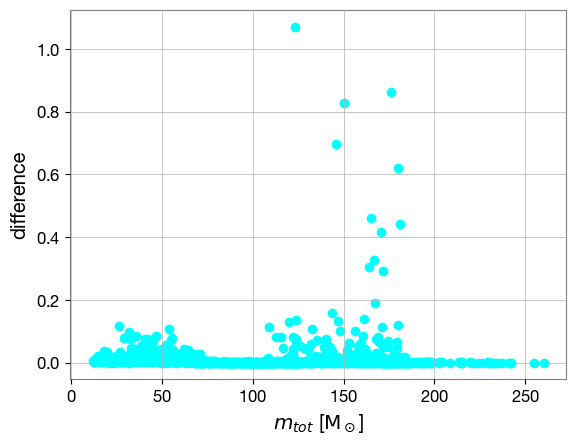

In [10]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()

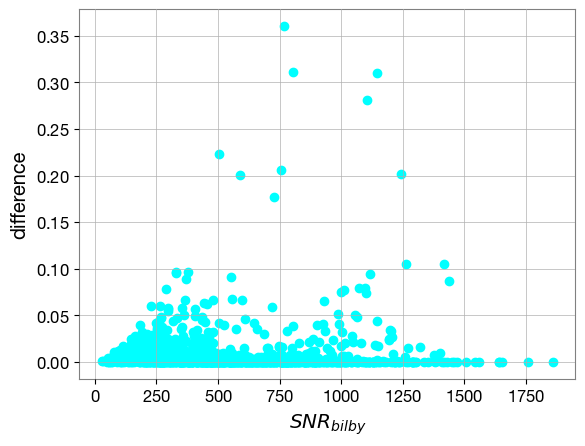

In [13]:
plt.plot(bilby_['opt_snr_net'], abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

* close enough

In [1]:
from gwsnr.njit_functions import findchirp_chirptime

In [3]:
findchirp_chirptime(23.2,2.59,20)

10.266117530390149

In [4]:
findchirp_chirptime(30.84822505374744,1.5424112526873723,20)

13.373456005049631

In [5]:
findchirp_chirptime(5.815409780896142,5.815409780896142,20)

14.955909104177683